In [1]:
# Copyright (c) 2024 Graphcore Ltd. All rights reserved.

In [2]:
import numpy as np
import sympy as sp
import scipy.special as ssp
import matplotlib.pyplot as plt
import functools as ft
from mess.structure import Structure
from mess.interop import to_pyscf
from pyscf import dft
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
import numpy.polynomial as npp
# %matplotlib widget

In [2]:
t, x = sp.symbols("t, x", real=True, nonnegative=True)
n = sp.symbols("n", integer=True, nonnegative=True)

f_nx = sp.Integral(t ** (2 * n) * sp.exp(-x * t**2), (t, 0, 1))
sp.simplify(f_nx.doit())

x**(-n - 1/2)*lowergamma(n + 1/2, x)/2

In [4]:
f_nx.subs(x, 0).doit()

1/(2*n + 1)

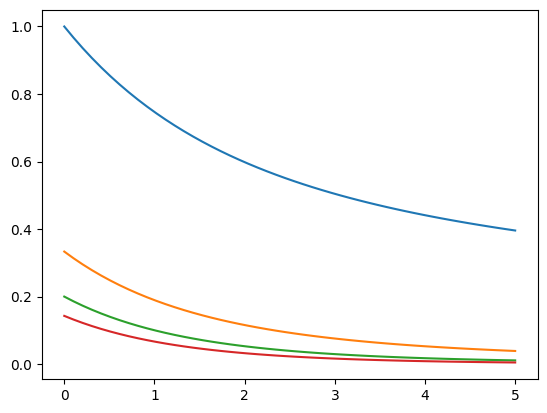

In [3]:
def boys_integral(n: int, x: float):
    from scipy.special import gamma, gammainc

    nh = n + 0.5
    xs = np.where(x == 0, 1, x)
    y0 = 1 / (2.0 * n + 1.0)
    return np.where(x == 0, y0, 0.5 * xs**-nh * gamma(nh) * gammainc(nh, xs))


x = np.linspace(0, 5)
for n in range(4):
    plt.plot(x, boys_integral(n, x))

Recurrence for Boys integral:
$$
(2 m - 1) F_{m-1}(x) = 2x F_m(x) + \exp(-x)
$$


In [9]:
n = 48
fnm1 = (1 / (2 * n - 1)) * (2 * x * boys_integral(n, x) + np.exp(-x))
np.allclose(boys_integral(n - 1, x), fnm1)

True

In [70]:
list(range(4, -1, -1))

[4, 3, 2, 1, 0]

In [84]:
def boys_table(x, nmax=16):
    out = np.zeros(nmax)
    fn = boys_integral(nmax, x)

    for n in range(nmax, 0, -1):
        out[n - 1] = (2 * x * fn + np.exp(-x)) / (2 * n - 1)
        fn = out[n - 1]

    return out


np.allclose(boys_table(10), np.asarray([boys_integral(n, 10) for n in range(16)]))

True

18

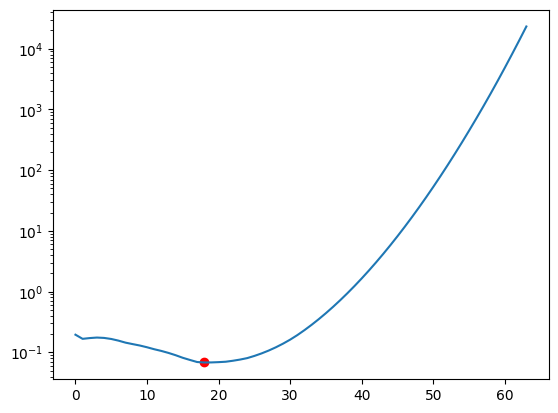

In [60]:
num_samples = 1000
x = np.logspace(-2, 3, num_samples)
# x = np.linspace(0, 200, num_samples)
n = 1
y = boys_integral(n, x)
# plt.plot(x, y)

e = []
for d in range(0, 64):
    f = npp.Chebyshev.fit(x, y, d)
    xx, yy = f.linspace(num_samples)
    e += [np.max(np.abs(boys_integral(n, xx) - yy))]

e = np.asarray(e)
plt.plot(e)
plt.yscale("log")
plt.scatter(np.argmin(e), np.min(e), color="r")
np.argmin(e)

In [ ]:
def build_h2(r: float):
    pos = np.zeros((2, 3))
    pos[0, 0] = r
    pos[1, 0] = -r
    return Structure(atomic_number=np.asarray([1, 1]), position=pos)


mol = build_h2(5.0)
mol = to_pyscf(mol)
grids = dft.gen_grid.Grids(mol)
grids.build()
weights, points = grids.weights, grids.coords

z0 = points[:, 2] == 0
weights = weights[z0]
x, y = points[z0, 0], points[z0, 1]
plt.scatter(x, y, 10 * np.abs(weights), weights)
plt.colorbar()
plt.title("$H_2$ Integration Grid z = 0")
plt.xlabel("x")
plt.ylabel("y")

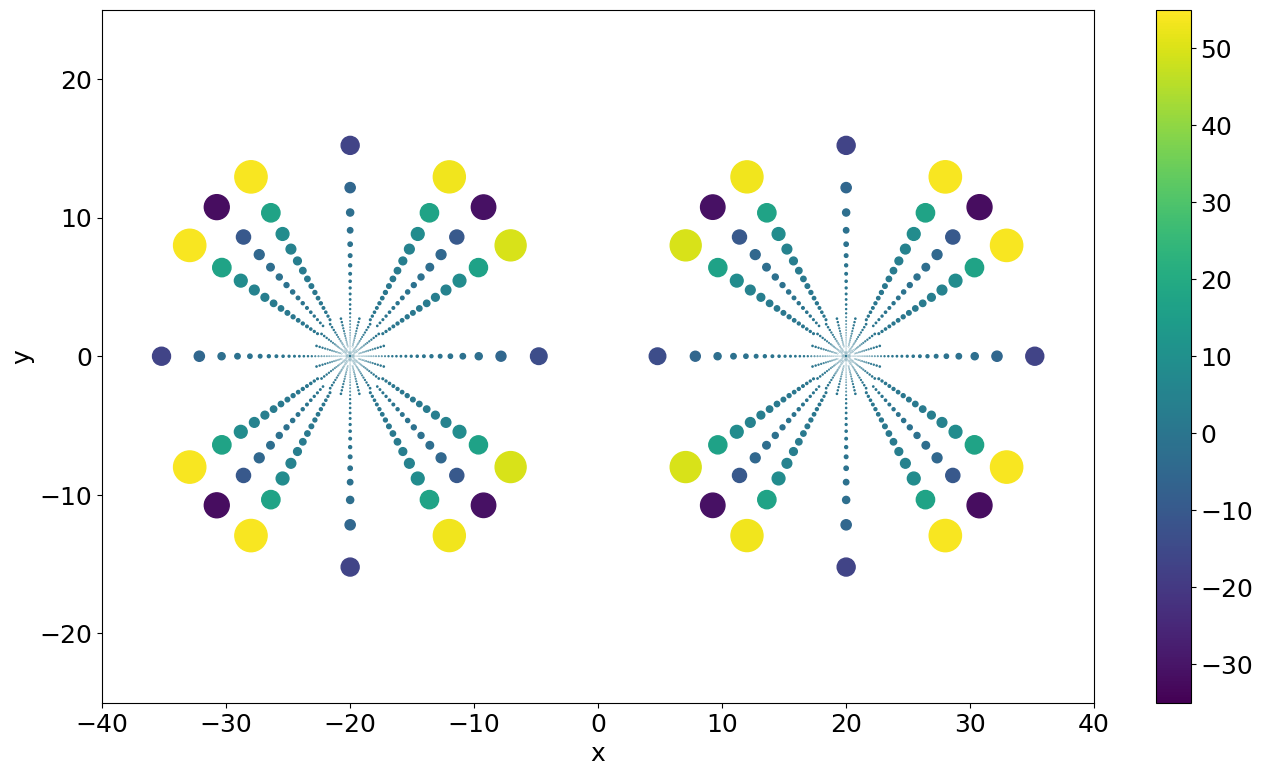

In [41]:
def build_grid(r: float):
    pos = np.zeros((2, 3))
    pos[0, 0] = r
    pos[1, 0] = -r
    mol = Structure(atomic_number=np.asarray([1, 1]), position=pos)
    mol = to_pyscf(mol)
    grids = dft.gen_grid.Grids(mol)
    grids.build()
    weights, points = grids.weights, grids.coords

    z0 = points[:, 2] == 0
    weights = weights[z0]
    x, y = points[z0, 0], points[z0, 1]
    return x, y, weights


data = [build_grid(r) for r in np.linspace(1.0, 20.0, 30)]
num_frames = len(data)
fig, ax = plt.subplots()
h = ax.scatter([], [], [], [], vmin=-35, vmax=55)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(-40, 40)
ax.set_ylim(-25, 25)
cb = fig.colorbar(h)


def update(i):
    x, y, w = data[i]
    h.set_offsets(np.vstack((x, y)).T)
    h.set_sizes(10 * np.abs(w))
    h.set_array(w)
    fig.colorbar(h, cax=cb.ax)
    return (h,)


ani = FuncAnimation(fig, update, frames=len(data), interval=100, blit=True)
HTML(ani.to_html5_video())

In [42]:
writer = PillowWriter(fps=5, bitrate=1800)
ani.save("scatter.gif", writer=writer)

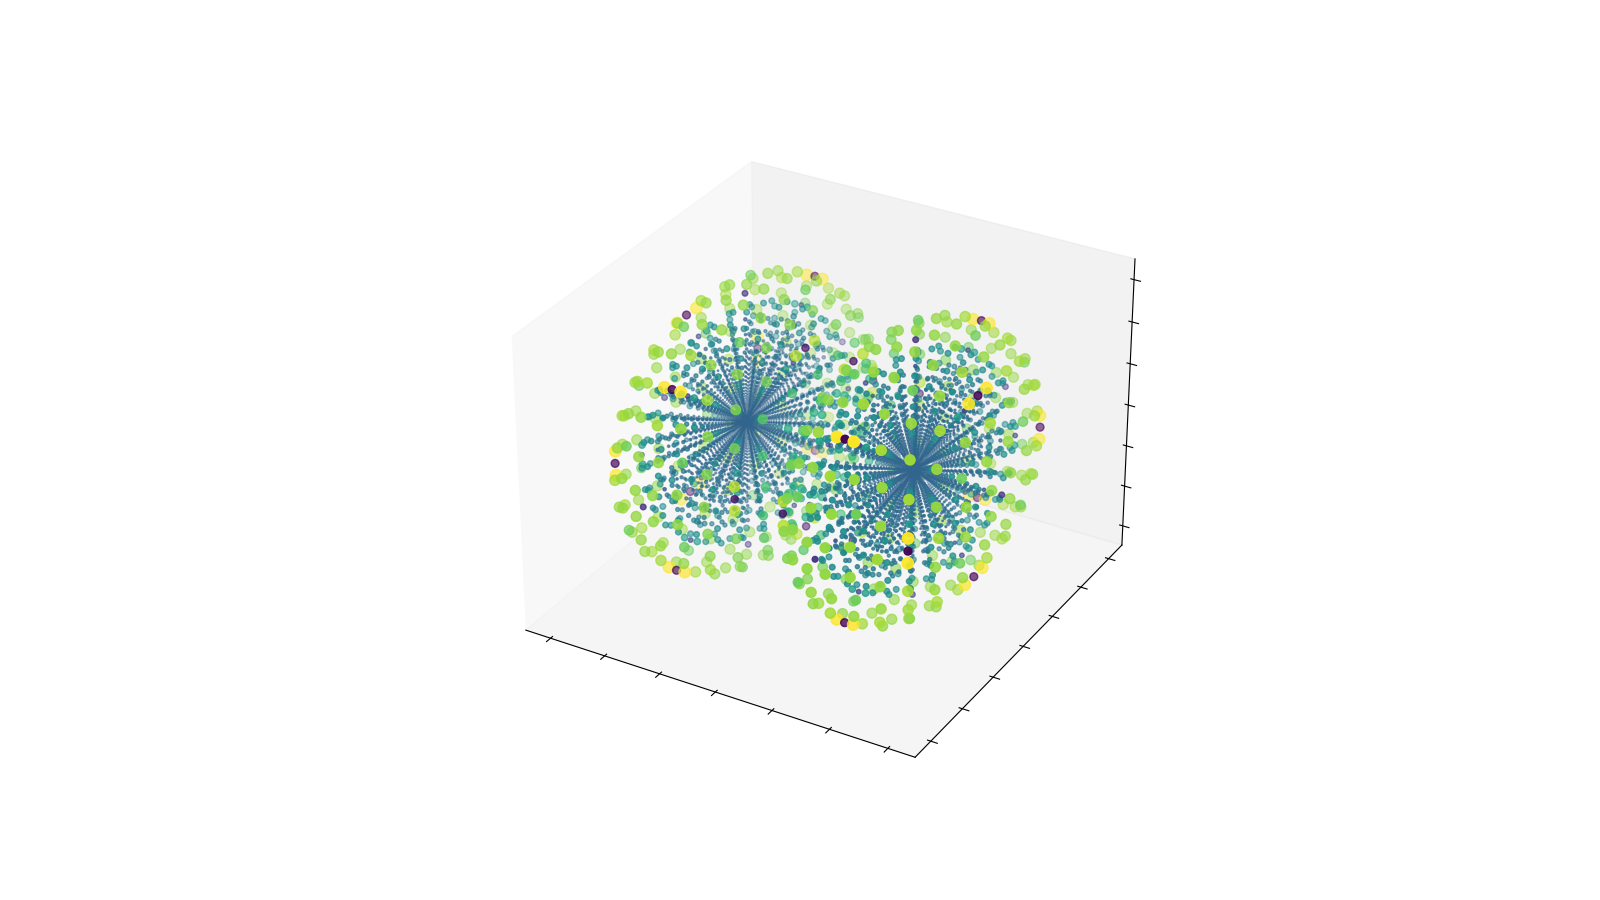

In [6]:
def build_grid(r: float):
    pos = np.zeros((2, 3))
    pos[0, 0] = r
    pos[1, 0] = -r
    mol = Structure(atomic_number=np.asarray([1, 1]), position=pos)
    mol = to_pyscf(mol)
    grids = dft.gen_grid.Grids(mol)
    grids.build()
    return grids.weights, grids.coords


weights, points = build_grid(15.0)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.view_init(elev=90, azim=-90, roll=0)
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=np.abs(weights), c=weights)
ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
ax.grid(False)


plt.show()

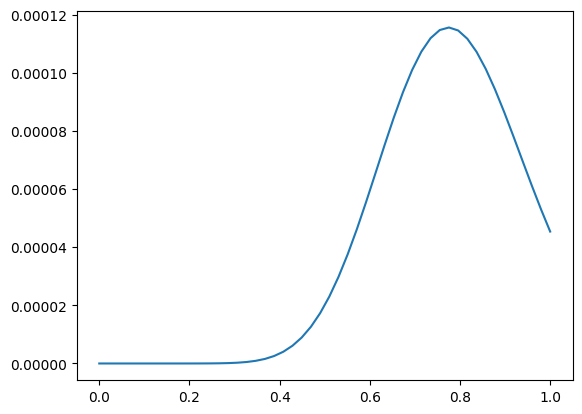

In [36]:
x = np.linspace(0, 1)
z = 10.0
n = 6.0
f = np.exp(-z * x**2) * x ** (2 * n)

plt.plot(x, f)

In [21]:
def jacobi(order, p=1.0, q=1.0):
    return ssp.roots_sh_jacobi(order, p, q)


@ft.cache
def legendre(order):
    return ssp.roots_sh_legendre(order)


def boys(n, z, order=4, use_jacobi=True):
    x, w = jacobi(order) if use_jacobi else legendre(order)
    z = np.atleast_1d(z)
    v = np.exp(-z[:, None] * x[None, :] ** 2) * x ** (2 * n)
    return np.inner(w, v)


def F(n, z):
    t = n + 0.5
    zs = np.where(z == 0, 1.0, z)
    f0 = 1 / (2 * n + 1)
    return np.where(z == 0, f0, 0.5 * zs**-t * ssp.gamma(t) * ssp.gammainc(t, zs))


n, x = 4, 10.0
expect, actual = F(n, x), boys(n, x, order=16, use_jacobi=False)
aerr = np.abs(expect - actual)
rerr = aerr / expect

aerr, rerr

(array([1.68051337e-18]), array([9.30416682e-15]))

Text(0, 0.5, 'Relative Error')

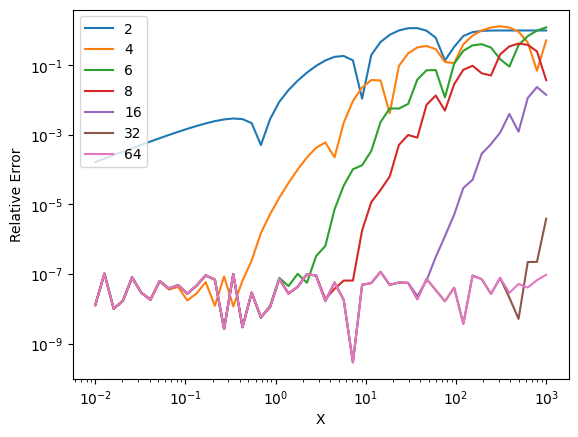

In [26]:
x = np.logspace(-2, 3, dtype=np.float32)
n = 1
for order in [2, 4, 6, 8, 16, 32, 64]:
    expect, actual = F(n, x), boys(n, x, order, use_jacobi=False)
    err = np.abs(expect - actual) / expect
    plt.plot(x, err, label=f"{order}")

plt.loglog()
plt.legend()
plt.xlabel("X")
plt.ylabel("Relative Error")

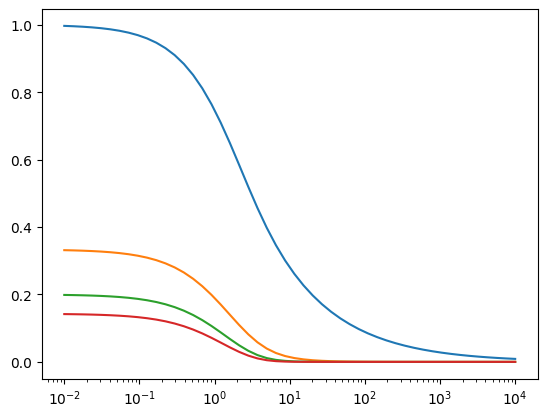

In [55]:
x = np.logspace(-2, 4)
for n in range(4):
    plt.plot(x, F(n, x))
plt.xscale("log")

In [129]:
%%timeit
boys(2, x, order=64, use_jacobi=False)

16.1 µs ± 338 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [130]:
%%timeit
F(2, x)

7.76 µs ± 43.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
x = np.logspace(-2, 3, dtype=np.float32)
n = 1

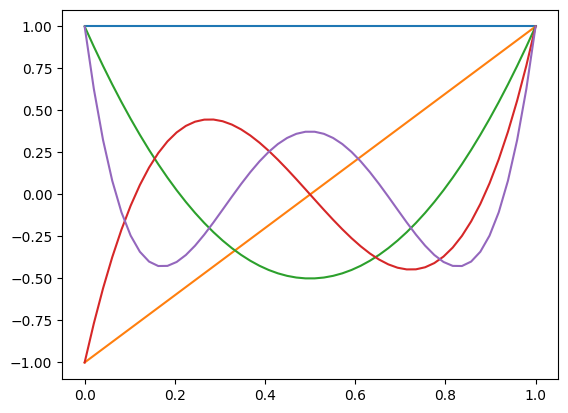

In [51]:
x = np.linspace(0, 1)
for n in range(5):
    y = ssp.eval_sh_legendre(n, x)
    plt.plot(x, y)

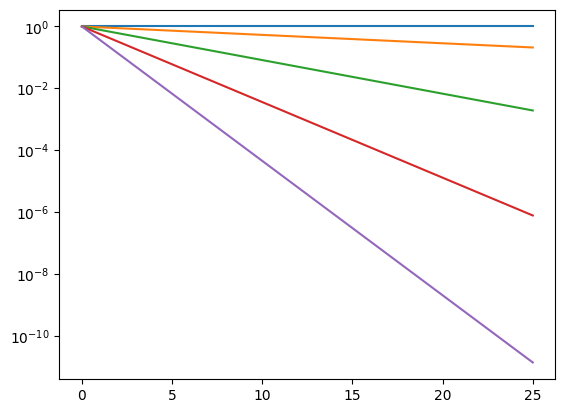

In [53]:
def w(x, t):
    return np.exp(-x * t**2)


x = np.linspace(0, 25)

for t in np.linspace(0, 1, 5):
    plt.plot(x, w(x, t))

plt.yscale("log")